In [311]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_2
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


### Financial data loads and cleaning

In [313]:
# BNP Data
#bnp = pd.read_csv(r'financial_data/bnp_data.csv', parse_dates =True, sep=";", header= [3], index_col=0)
#bnp_wanted_ticker = ["US_USDLIBOR3M","USD_EUR"]
#bnp

In [314]:
# yahoo_prices
yahoo = pd.read_csv(r"financial_data/yahoo_prices.csv", index_col=0, parse_dates=True, dayfirst=True)

# MSCI
msci = pd.read_csv(r'financial_data/msci_data.csv', index_col=0, parse_dates=True, sep=";")

# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[['HFRXEMN']].dropna(), US_rate)

# BNP
bnp_all = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]
bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU', 'BNPIFUS', 'BNPIFUSC',
                            'BNPIFJP', 'BNPIFGB', 'BNPIFCH', 'BNPIFEM', 'BPFXEUR1', 'BPFXGBP1', 'BPFXJPY1']]

In [315]:
prices = bnp.copy()
#prices = prices.join(msci, how="outer")
prices = prices.join(hfrx,how="outer")

prices_all = bnp_all.copy()
#prices = prices.join(msci, how="outer")
prices_all = prices_all.join(hfrx,how="outer")

In [316]:
starts = prices.apply(lambda x:x.first_valid_index())

In [317]:
prices = prices.ffill().dropna()
returns = prices.resample('7D').first().pct_change().dropna()

prices_all = prices_all.ffill().dropna()
returns_all = prices_all.resample('7D').first().pct_change().dropna()

In [318]:
hrfx_returns = returns[["HFRXEMN"]]
bch_returns = returns.drop("HFRXEMN", axis=1)
bch_returns_all = returns_all.drop("HFRXEMN", axis=1)

size = 104
freq = 13
bounds = (-np.inf,np.inf)
total_weight = np.nan

df_weight = ols_regression(hrfx_returns, bch_returns, size, freq, boundaries=bounds, weight_sum=total_weight)
df_weight_all = ols_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight)

prices_for_track = prices.loc[df_weight.index[0]:].drop("HFRXEMN", axis=1)
replication = make_track(prices_for_track, df_weight)

prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("HFRXEMN", axis=1)
replication_all = make_track(prices_for_track_all, df_weight_all)

df_res = prices.loc[replication.index][["HFRXEMN"]]
df_res["OLS"] = replication
df_res["OLS all"] = replication_all

1
1


In [319]:
df_weight_lasso = lasso_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight, l=0.05)
replication_lasso = make_track(prices_for_track_all, df_weight_lasso)
df_res["Lasso"] = replication_lasso

1


In [320]:
df_weight_lasso2 = lasso_regression_2(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds,
                                       weight_sum=total_weight, l1=0.04, l2=1.5)
replication_lasso2 = make_track(prices_for_track_all, df_weight_lasso2)
df_res["Lasso 2"] = replication_lasso2
df_res = df_res / df_res.iloc[0]

1


(0, 1.3)

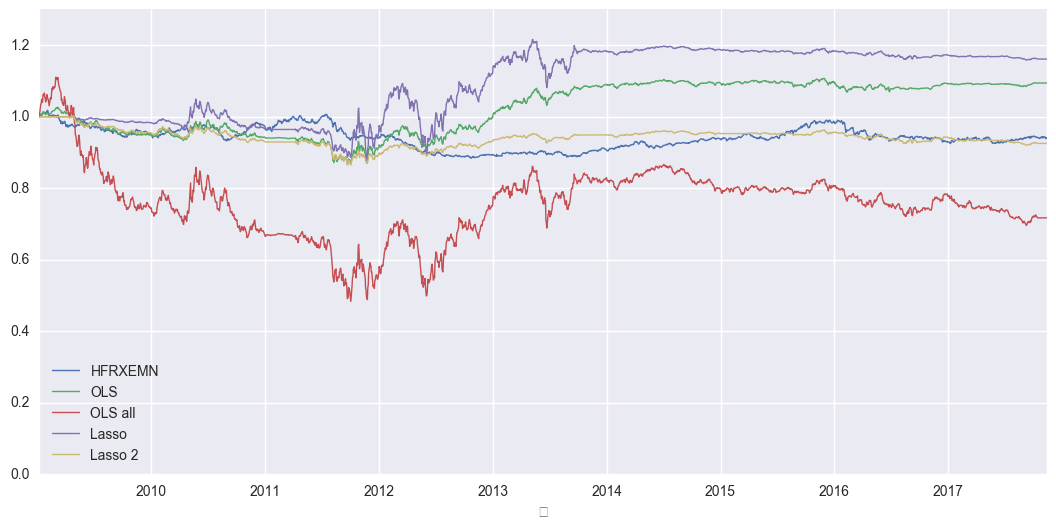

In [321]:
df_res.plot(figsize=(13,6), linewidth=1)
plt.gca().set_ylim(bottom=0)

In [322]:
g = hc_stock(df_res)
g.plot()

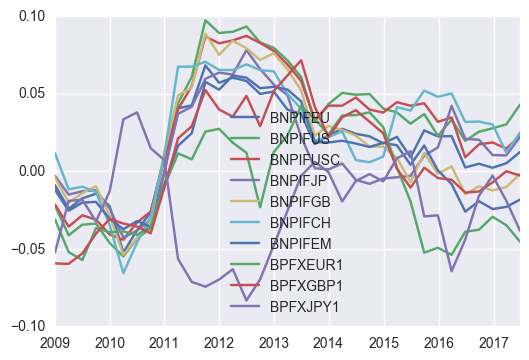

In [323]:
df_weight.plot()

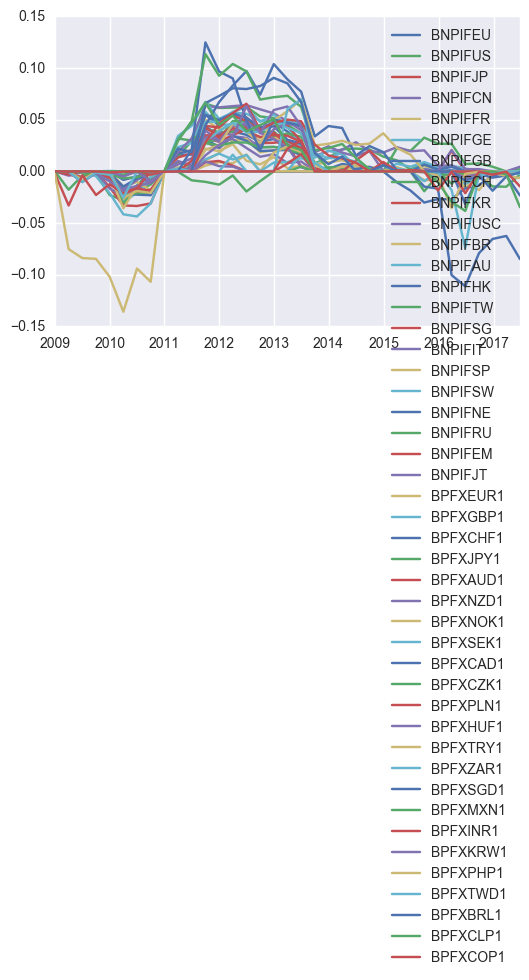

In [324]:
df_weight_lasso.plot()